In [4]:
import SimpleITK as sitk
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from ipywidgets import interact
from ipywidgets.widgets import IntSlider
import cv2
import ants as ants
import matplotlib.pyplot as plt
import pydicom
from matplotlib.colors import ListedColormap
import os
import PerfusionImaging.tool as perfusion
from scipy import ndimage
import ImageTool.tool as tool
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import pandas as pd
from totalsegmentator.python_api import totalsegmentator
import nibabel as nib
import matplotlib
from scipy import ndimage

In [5]:
parameters = {
    'input_conc_retro': 0,
    'input_conc_pro': 0,
    'times_retro': [],
    'times_pro': [],
    'idx_retro': 0,
    'idx_pro': 0,
    'fixed_sample': 7,
    'aorta_slice': 15
}

# include the path to the file. 

In [6]:
root = "/home/molloi-lab-linux2/smb_mount/Alireza/Brain/TTP/Buffalo_Cerebral/Data"
target = "CTP0115"
save_path = os.path.join("/home/molloi-lab-linux2/Desktop/ZQY/Project perfusion/brain", target)
tool.make_if_dont_exist(save_path)
target = os.path.join(root, target + "/DICOM")
imgs = []
paths = []
for i in sorted(os.listdir(target), key=lambda x: int(x)):
    reg_sample = os.path.join(target, i)
    reg_dcm = [i for i in os.listdir(reg_sample)][0]
    reg_dcm = os.path.join(reg_sample, reg_dcm)
    imgs.append(ants.image_read(reg_dcm))
    paths.append(reg_dcm)
    

Register all dcm images within the patient. It may takes long time!!(22 min)

In [7]:
fixed_sample = parameters["fixed_sample"]
for i in range(len(imgs)):
    if i != fixed_sample:
        imgs[i] = ants.registration(fixed = imgs[fixed_sample] , moving = imgs[i], type_of_transform = 'SyN')["warpedmovout"]

# Read the mask file

In [8]:
dcm_img = sitk.ReadImage(paths[parameters["fixed_sample"]])
sitk.WriteImage(dcm_img, "tmp.nii")
output_img = totalsegmentator("tmp.nii", task = "brain_structures")
image_array = output_img.get_fdata()
image_array[image_array > 0] = 1
image_array = image_array.astype(np.int16)
new_img = nib.Nifti1Image(image_array, output_img.affine, output_img.header)
        # print(out_path, label_mask_path)
nib.save(new_img, os.path.join(save_path, "mask.nii"))
mask = ants.image_read(os.path.join(save_path, "mask.nii"))
os.remove("tmp.nii")


If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Resampling...
  Resampled in 1.16s
Predicting...


torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
┌ Warning: CUDA runtime library `libcudart.so.12` was loaded from a system path, `/home/molloi-lab-linux2/anaconda3/lib/python3.9/site-packages/torch/lib/../../nvidia/cuda_runtime/lib/libcudart.so.12`.
│ 
│ This may cause errors. Ensure that you have not set the LD_LIBRARY_PATH
│ environment variable, or that it does not contain paths to CUDA libraries.
│ 
│ In any other case, please file an issue.
└ @ CUDA ~/.julia/packages/CUDA/75aiI/src/initialization.jl:219
┌ Warning: CUDA runtime library `libcupti.so.12` was loaded from a system path, `/home/molloi-lab-linux2/anaconda3/lib/python3.9/site-packages/torch/lib/../../nvidia/cuda_cupti/lib/libcupti.so.12`.
│ 
│ This may cause errors. Ensure that you have not set the LD_LIBRARY_PATH
│ environment variable, or that it does not contain paths to CUDA librari

  Predicted in 10.95s
Resampling...
  cropping from (512, 512, 160) to (415, 459, 160)
Resampling...
  Resampled in 3.53s
Predicting...


100%|██████████| 64/64 [00:02<00:00, 22.22it/s]


  Predicted in 32.97s
Resampling...


# Calculate the time point in surestart and v2

In [9]:
def scan_time_vector(dcm_folders):
    def dcm_time_to_sec(dcm_time):
        hr = float(dcm_time[0:2])
        minute = float(dcm_time[2:4])
        sec = float(dcm_time[4:6])
        ms = float(dcm_time[6:]) if len(dcm_time) > 6 else 0.0  # Handle cases without milliseconds
        return hr * 3600 + minute * 60 + sec + ms
    scan_times = []
    for dcm_file in sorted(os.listdir(dcm_folders), key = lambda x: int(x)):
        sample_path = os.path.join(dcm_folders, dcm_file)
        dcm_file = [i for i in os.listdir(sample_path)][0]
        dcm_file = os.path.join(sample_path, dcm_file)
        # Read DICOM file
        dcm = pydicom.dcmread(dcm_file)
        # Extract Content Time and convert to seconds
        content_time = dcm.get("ContentTime")  # Default to "000000.00" if missing
        # print(content_time)
        scan_time = dcm_time_to_sec(content_time)
        scan_times.append(scan_time)
    # Sort scan times
    return scan_times

In [10]:
times = scan_time_vector(target)
sort_idx = np.argsort(times)
imgs = np.array(imgs)[sort_idx]
times = np.array(times)[sort_idx]
times = [i-times[0] for i in times]


In [23]:
%matplotlib inline
tool.list_display([imgs[0], imgs[4], imgs[7], imgs[10], 300 * mask[:]], cmap="gray")
parameters['aorta_slice'] = 5
samples = [imgs[i][:,:,parameters["aorta_slice"]] for i in range(len(imgs))]
samples = np.stack(samples, axis = 2)
samples.shape

interactive(children=(IntSlider(value=0, description='Slice:', max=159), Output()), _dom_classes=('widget-inte…

(512, 512, 19)

# Find the aera under the curve as input_conc

In [ ]:
%matplotlib inline
def plot_slice4(slice_index, drop_num, x, y, r):
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(30, 10))
    times_ = times[:len(times)-drop_num]
    pcm = ax0.imshow(samples[:,:,slice_index], cmap='gray', vmin=0, vmax=300)
    ax0.set_title("rest")
    phi = np.linspace(0, 2 * np.pi, 100)
    circle_x = r * np.cos(phi) + x
    circle_y = r * np.sin(phi) + y
    ax0.plot(circle_x, circle_y, label=f"Aorta Mask (radius {r})", color="red", linewidth=1)
    ss_rest_value = perfusion.compute_aif(samples[:, :, :len(times)-drop_num], x, y, r)
    np.save("brain_para.npy", [x, y, r, drop_num])
        
    try:
        parameters["input_conc_retro"], parameters["idx_retro"] = perfusion.gamma_plot(ax1, times_, ss_rest_value, triger = False)
        parameters["input_conc_pro"], parameters["idx_pro"] = perfusion.gamma_plot(ax2, times_, ss_rest_value, triger = True)
        fig.savefig(os.path.join(save_path, 'gamma.png'))
        # parameters["input_conc_retro"] = perfusion.gamma_plot(ax1, parameters["times_retro"], ss_rest_value2, triger = False)
        
        # parameters["input_conc_pro"] = gamma_plot(ax3, parameters["times_pro"], ss_rest_value3, triger= True)
    except:
        pass
    
if os.path.exists("brain_para.npy"):
    x, y, r, drop_num = np.load("brain_para.npy")
else:
    x, y, r, drop_num = 0, 0, 8, 10
    
slice_index=IntSlider(max = len(times) - 1, value = 0)
drop_num = IntSlider(max = len(times) - 1, value = drop_num)
x = IntSlider(min = 15, max = 512 - 15, value = x) 
y = IntSlider(min = 15, max = 512 - 15, value = y)   
r = IntSlider(max = 14, value = r)

interact(plot_slice4, slice_index = slice_index, drop_num = drop_num, x = x, y = y, r = r)

interactive(children=(IntSlider(value=0, description='slice_index', max=18), IntSlider(value=12, description='…

<function __main__.plot_slice4(slice_index, drop_num, x, y, r)>

# Calculate the result of perfusion in retrospective way

In [18]:
result = perfusion.compute_organ_metrics(imgs[parameters["idx_retro"]], mask, imgs[0], parameters["input_conc_retro"], tissue_rho=1.081)
col_vals = [result["perf"], result["perf_std"], result["flow"], result["flow_std"], result["organ_mass"], target]
col_names = ["perfusion", "perfusion_std", "flow", "flow_std", "mass", "date"]
df = pd.DataFrame({"parameters": col_names, "values": col_vals})
df.to_csv(os.path.join(save_path, "retro.csv"))
np.save(os.path.join(save_path, "retro.npy"), result["perf_map"])
df

,parameters,values
0,perfusion,0.157131
1,perfusion_std,0.513479
2,flow,214.227111
3,flow_std,700.062317
4,mass,1363.370495
5,date,/home/molloi-lab-linux2/smb_mount/Alireza/Brai...


# Calculate the result of perfusion in prospective way

In [19]:
result2 = perfusion.compute_organ_metrics(imgs[parameters["idx_pro"]], mask, imgs[0], parameters["input_conc_pro"], tissue_rho=1.081)
col_vals = [result2["perf"], result2["perf_std"], result2["flow"], result2["flow_std"], result2["organ_mass"], target]
df2 = pd.DataFrame({"parameters": col_names, "values": col_vals})
df2.to_csv(os.path.join(save_path, "pro.csv"))
np.save(os.path.join(save_path, "pro.npy"), result2["perf_map"])
df2

,parameters,values
0,perfusion,0.155336
1,perfusion_std,0.507616
2,flow,211.781079
3,flow_std,692.068787
4,mass,1363.370495
5,date,/home/molloi-lab-linux2/smb_mount/Alireza/Brai...


In [20]:
tool.list_display([result["perf_map"],result2["perf_map"]], vmax = 1, cmap="jet")


interactive(children=(IntSlider(value=0, description='Slice:', max=159), Output()), _dom_classes=('widget-inte…

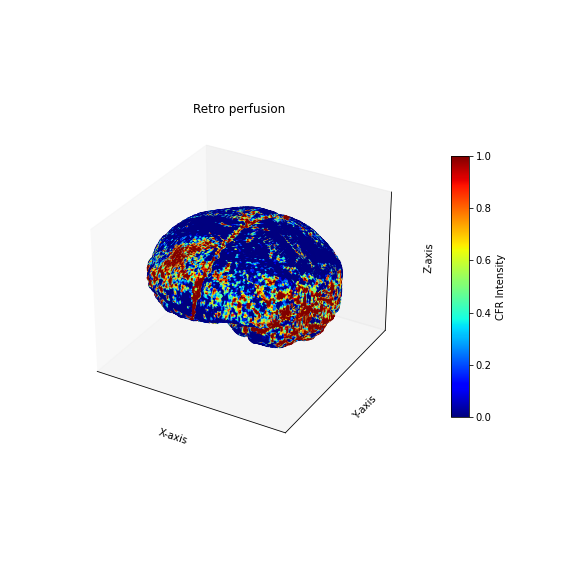

In [21]:
%matplotlib notebook
tool.plot3d(result["perf_map"], mask = mask, sample_rate = 1, vmax=1, title="Retro perfusion", save_path = os.path.join(save_path, "Retro perfusion.png"))

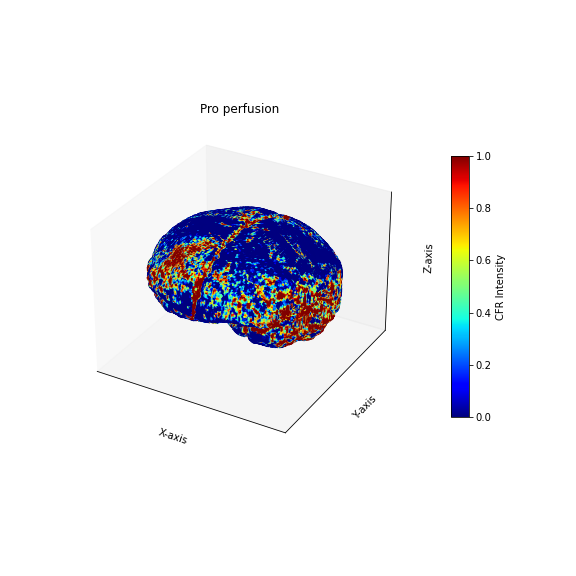

In [22]:
%matplotlib notebook
tool.plot3d(result2["perf_map"], mask = mask, sample_rate=1, vmax=1, title="Pro perfusion", save_path = os.path.join(save_path, "Pro perfusion.png"))